<a href="https://colab.research.google.com/github/Jaber521/fraud_detection/blob/main/fraud_model_and_gradio_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💳 Détection de Fraude — Entraînement du modèle + Interface Gradio complète

In [1]:
from google.colab import files

uploaded = files.upload()

Saving code_generation_dataset_final.csv to code_generation_dataset_final.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib


In [3]:
# Charger la data
df = pd.read_csv("code_generation_dataset_final.csv")
df['INTERNAL_TRANSMISSION_TIME'] = pd.to_datetime(df['INTERNAL_TRANSMISSION_TIME'])
df['FRAUDULANT'] = df['FRAUDULANT'].map({'Y': 1, 'N': 0})


In [4]:
# Features temporelles
df['HOUR'] = df['INTERNAL_TRANSMISSION_TIME'].dt.hour
df['DAY'] = df['INTERNAL_TRANSMISSION_TIME'].dt.day
df['WEEKDAY'] = df['INTERNAL_TRANSMISSION_TIME'].dt.weekday


In [5]:
# Colonnes utilisées dans le modèle
columns_to_keep = [
    'TRANSACTION_AMOUNT', 'AVG_CARD_AMOUNT', 'PREVIOUS_DECLINED_ATTEMPTS',
    'DISTANCE_FROM_PREV_KM', 'TIME_DIFF_MINUTES', 'IS_GEOLOGICALLY_IMPOSSIBLE',
    'IS_NIGHT', 'TRANSACTION_COUNTRY', 'CARD_ACCEPTOR_ACTIVITY', 'POS_ENTRY_MODE',
    'HOUR', 'DAY', 'WEEKDAY',
    'BILLING_AMOUNT', 'ACQUIRING_COUNTRY_CODE', 'CARD_SEQUENCE_NUMBER',
    'ISS_SETTLEMENT_AMOUNT', 'EXTERNAL_STAN', 'DAYS_BEFORE_EXPIRY',
    'PROCESSING_CODE', 'CASE_AFTER_EXPIRY', 'CASE_LONG_AFTER_EXPIRY',
    'CASE_CLOSE_TO_EXPIRY', 'CASE_OK_ACTIVE'
]
X = df[columns_to_keep]
y = df['FRAUDULANT']


In [6]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in X.columns if col not in categorical_cols]


In [7]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)


In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       230
           1       1.00      0.97      0.98        60

    accuracy                           0.99       290
   macro avg       1.00      0.98      0.99       290
weighted avg       0.99      0.99      0.99       290



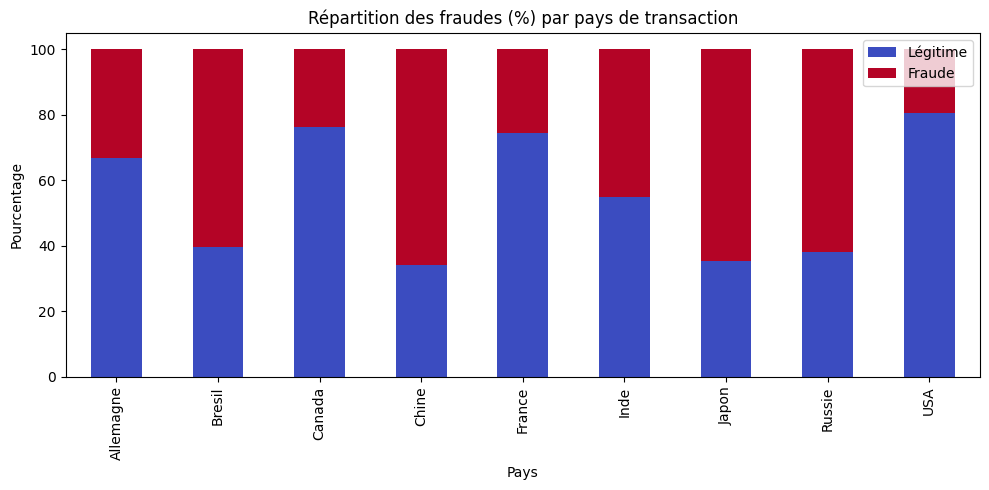

In [11]:
pivot_country = pd.crosstab(df['TRANSACTION_COUNTRY'], df['FRAUDULANT'], normalize='index') * 100
pivot_country.plot(kind='bar', stacked=True, figsize=(10,5), colormap='coolwarm')
plt.title("Répartition des fraudes (%) par pays de transaction")
plt.xlabel("Pays")
plt.ylabel("Pourcentage")
plt.legend(["Légitime", "Fraude"])
plt.tight_layout()
plt.show()


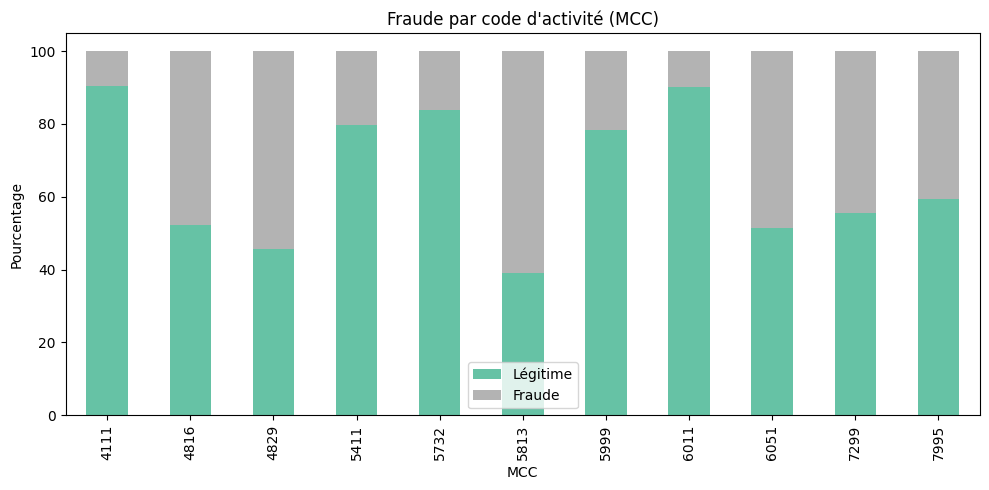

In [12]:
pivot_mcc = pd.crosstab(df['CARD_ACCEPTOR_ACTIVITY'], df['FRAUDULANT'], normalize='index') * 100
pivot_mcc.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Set2')
plt.title("Fraude par code d'activité (MCC)")
plt.xlabel("MCC")
plt.ylabel("Pourcentage")
plt.legend(["Légitime", "Fraude"])
plt.tight_layout()
plt.show()


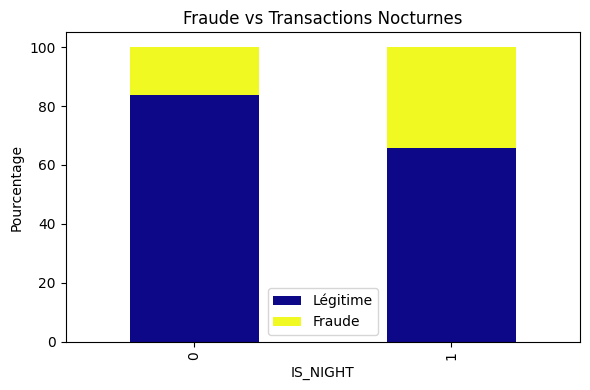

In [13]:
pivot_night = pd.crosstab(df['IS_NIGHT'], df['FRAUDULANT'], normalize='index') * 100
pivot_night.plot(kind='bar', stacked=True, figsize=(6,4), colormap='plasma')
plt.title("Fraude vs Transactions Nocturnes")
plt.xlabel("IS_NIGHT")
plt.ylabel("Pourcentage")
plt.legend(["Légitime", "Fraude"])
plt.tight_layout()
plt.show()


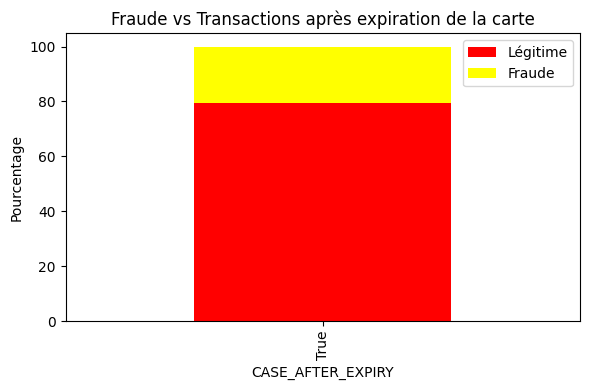

In [14]:
pivot_expiry = pd.crosstab(df['CASE_AFTER_EXPIRY'], df['FRAUDULANT'], normalize='index') * 100
pivot_expiry.plot(kind='bar', stacked=True, figsize=(6,4), colormap='autumn')
plt.title("Fraude vs Transactions après expiration de la carte")
plt.xlabel("CASE_AFTER_EXPIRY")
plt.ylabel("Pourcentage")
plt.legend(["Légitime", "Fraude"])
plt.tight_layout()
plt.show()


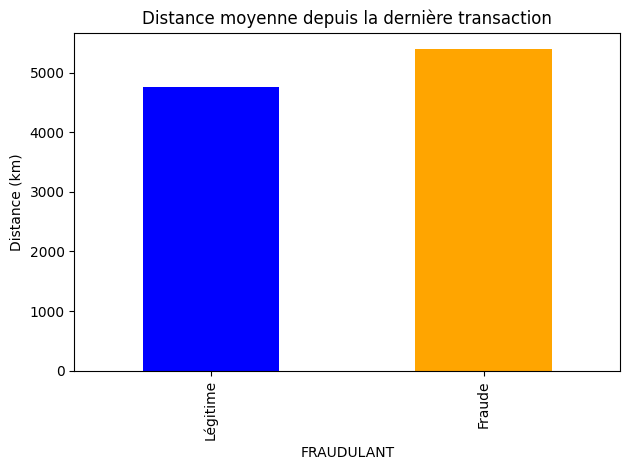

In [15]:
df.groupby('FRAUDULANT')['DISTANCE_FROM_PREV_KM'].mean().plot(kind='bar', color=['blue', 'orange'])
plt.title("Distance moyenne depuis la dernière transaction")
plt.xticks([0, 1], ['Légitime', 'Fraude'])
plt.ylabel("Distance (km)")
plt.tight_layout()
plt.show()


In [16]:
joblib.dump(pipeline, "fraud_detection_model_rf_final.pkl")


['fraud_detection_model_rf_final.pkl']

## 🎛️ Interface Gradio pour prédiction

In [17]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [18]:
import gradio as gr

model = joblib.load("fraud_detection_model_rf_final.pkl")

def predict_fraud_full(
    transaction_amount, avg_card_amount, declined_attempts,
    distance_from_prev_km, time_diff_minutes, is_geo_impossible,
    is_night, transaction_country, card_acceptor_activity, pos_entry_mode,
    internal_transmission_time, billing_amount, acquiring_country_code,
    card_sequence_number, iss_settlement_amount, external_stan,
    days_before_expiry, processing_code,
    case_after_expiry, case_long_after_expiry,
    case_close_to_expiry, case_ok_active
):
    try:
        internal_time = datetime.strptime(internal_transmission_time.strip().replace("/", "-"), "%Y-%m-%d %H:%M")
    except ValueError:
        return "⛔️ Format de date invalide. Utilisez : YYYY-MM-DD HH:MM"

    input_dict = {
        'TRANSACTION_AMOUNT': transaction_amount,
        'AVG_CARD_AMOUNT': avg_card_amount,
        'PREVIOUS_DECLINED_ATTEMPTS': declined_attempts,
        'DISTANCE_FROM_PREV_KM': distance_from_prev_km,
        'TIME_DIFF_MINUTES': time_diff_minutes,
        'IS_GEOLOGICALLY_IMPOSSIBLE': int(is_geo_impossible),
        'IS_NIGHT': int(is_night),
        'TRANSACTION_COUNTRY': str(transaction_country),
        'CARD_ACCEPTOR_ACTIVITY': str(card_acceptor_activity),
        'POS_ENTRY_MODE': str(pos_entry_mode),
        'HOUR': internal_time.hour,
        'DAY': internal_time.day,
        'WEEKDAY': internal_time.weekday(),
        'BILLING_AMOUNT': billing_amount,
        'ACQUIRING_COUNTRY_CODE': acquiring_country_code,
        'CARD_SEQUENCE_NUMBER': card_sequence_number,
        'ISS_SETTLEMENT_AMOUNT': iss_settlement_amount,
        'EXTERNAL_STAN': external_stan,
        'DAYS_BEFORE_EXPIRY': days_before_expiry,
        'PROCESSING_CODE': processing_code,
        'CASE_AFTER_EXPIRY': case_after_expiry,
        'CASE_LONG_AFTER_EXPIRY': case_long_after_expiry,
        'CASE_CLOSE_TO_EXPIRY': case_close_to_expiry,
        'CASE_OK_ACTIVE': case_ok_active
    }

    try:
        input_df = pd.DataFrame([input_dict])
        prediction = model.predict(input_df)[0]
        return "🔴 FRAUDE détectée" if prediction == 1 else "✅ Transaction légitime"
    except Exception as e:
        return f"⛔️ Erreur interne : {str(e)}"


In [21]:
gr.Interface(
    fn=predict_fraud_full,
    inputs=[
        gr.Number(label="Montant de la transaction"),
        gr.Number(label="Montant moyen de la carte"),
        gr.Number(label="Nombre de refus précédents"),
        gr.Number(label="Distance depuis dernière transaction (km)"),
        gr.Number(label="Temps depuis dernière transaction (minutes)"),
        gr.Checkbox(label="Distance impossible à parcourir"),
        gr.Checkbox(label="Transaction de nuit (entre 0h-5h)"),
        gr.Dropdown(choices=[
            'France', 'USA', 'Canada', 'Inde', 'Japon', 'Bresil', 'Allemagne',
            'Espagne', 'Italie', 'Russie', 'Chine', 'Australie', 'Maroc',
            'Afrique du Sud', 'Mexique'
        ], label="Pays de la transaction"),
        gr.Dropdown(choices=[5411, 5999, 5732, 7995, 5813, 4816, 4829, 6051, 7299], label="Code MCC (activité)"),
        gr.Dropdown(choices=['5010', '9010'], label="POS Entry Mode"),
        gr.Textbox(label="Date et heure (YYYY-MM-DD HH:MM)"),
        gr.Number(label="Montant facturé (billing_amount)"),
        gr.Textbox(label="Code pays acquéreur (ACQUIRING_COUNTRY_CODE)"),
        gr.Number(label="N° séquence carte"),
        gr.Number(label="Montant settlement (ISS_SETTLEMENT_AMOUNT)"),
        gr.Number(label="EXTERNAL STAN"),
        gr.Number(label="Jours avant expiration carte"),
        gr.Number(label="Processing code"),
        gr.Checkbox(label="CASE_AFTER_EXPIRY"),
        gr.Checkbox(label="CASE_LONG_AFTER_EXPIRY"),
        gr.Checkbox(label="CASE_CLOSE_TO_EXPIRY"),
        gr.Checkbox(label="CASE_OK_ACTIVE"),
    ],
    outputs="text",
    title="🛡️ Détection de Fraude - Random Forest (Modèle Complet)",
    description="Modèle entraîné avec toutes les colonnes de la dataset"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://96c412df63d59927bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
